In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clinvar-conflicting/clinvar_conflicting.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style='whitegrid')
sns.set(font_scale=1.5)

import pandas as pd
import re

In [3]:
df = pd.read_csv('/kaggle/input/clinvar-conflicting/clinvar_conflicting.csv', dtype={'CHROM':str, 38:str, 40:object})

In [4]:
df.CHROM.dtype

dtype('O')

In [5]:
df.shape

(65188, 46)

In [6]:
df.groupby(['CHROM', 'POS', 'REF', 'ALT']).ngroups

65188

In [7]:
df.groupby(['CHROM', 'POS', 'REF', 'ALT']).ngroups

65188

In [8]:
df.CHROM.value_counts().sort_values(ascending=False)

2     8645
17    5394
11    4846
1     4454
16    3927
19    3911
5     3643
7     2867
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
X     1926
8     1852
15    1725
4     1206
22    1135
18     896
21     843
20     759
MT      16
Name: CHROM, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

---

**The CLASS distribution is skewed a bit to the 0 class, meaning there are fewer variants with conflicting submissions.**

In [10]:
df.CLASS.value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

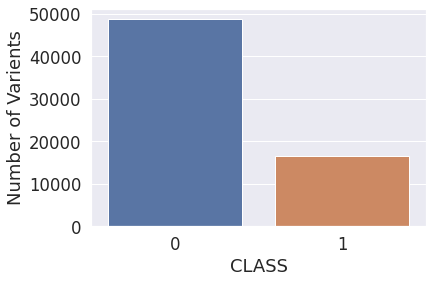

In [11]:
ax = sns.countplot(x="CLASS", data=df)
ax.set(xlabel='CLASS', ylabel='Number of Varients');

---

In [12]:
gene_ct = pd.crosstab(df.SYMBOL, df.CLASS, margins=True)

In [13]:
gene_ct

CLASS,0,1,All
SYMBOL,,,
A2ML1,19,2,21
AAAS,1,1,2
AARS,27,14,41
AARS2,13,8,21
ABAT,6,5,11
...,...,...,...
ZNF469,78,34,112
ZNF674,1,1,2
ZNF81,5,2,7


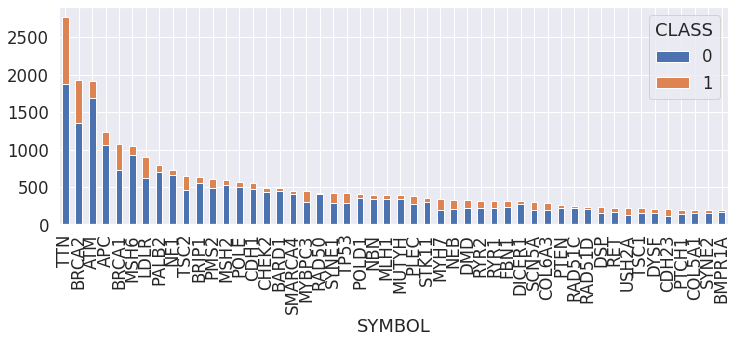

In [14]:
gene_ct = pd.crosstab(df.SYMBOL, df.CLASS, margins=True)
gene_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
gene_ct = gene_ct.sort_values(by='All', ascending=False).head(50)
gene_ct.drop('All', axis=1, inplace=True)

gene_ct.plot.bar(stacked=True, figsize=(12, 4));

**It's clear that conflicting variants are more common in some genes.**

---

CLNVC (Variant Type)

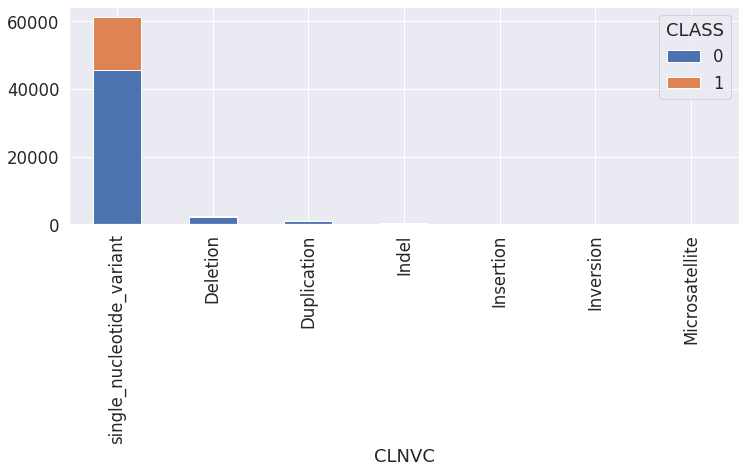

In [15]:
vt_ct = pd.crosstab(df.CLNVC, df.CLASS, margins=True)
vt_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
vt_ct = vt_ct.sort_values(by='All', ascending=False)
vt_ct.drop('All', axis=1, inplace=True)

vt_ct.plot.bar(stacked=True, figsize=(12, 4));

---
Exons are features of genes that map sequences nucleotides that encode functional parts of DNA. Genes have differing numbers of exons, some have few, some have many. Let's see if, regardless of gene, whether or not conflicting variants are enriched in a general exon location.

In [21]:
df.EXON.fillna('0', inplace=True)
df['variant_exon'] = df.EXON.apply(lambda x:[int(s) for s in re.findall(r'\b\d+\b', x)][0])

variant_exon = 0 represents that the variant is located in an Intron. Intron variants seem to be coflicting much more frequently than exon variants.

(-0.5, 20.5)

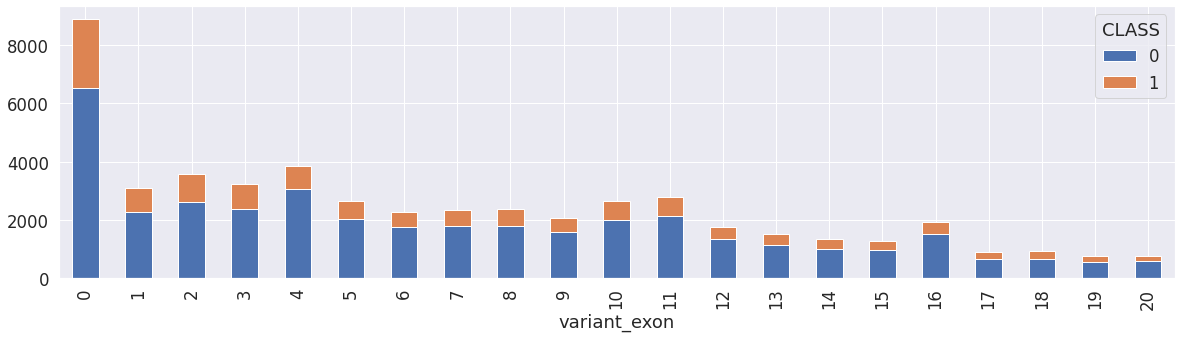

In [23]:
exondf = pd.crosstab(df['variant_exon'], df['CLASS'])
exondf.plot.bar(stacked=True, figsize=(20,5));
plt.xlim(-0.5, 20.5)

---
Parse and encode the MC (molecular consequence) field

In [31]:
df.MC

0                              SO:0001583|missense_variant
1                              SO:0001583|missense_variant
2        SO:0001583|missense_variant,SO:0001623|5_prime...
3                              SO:0001583|missense_variant
4                              SO:0001583|missense_variant
                               ...                        
65183                        SO:0001819|synonymous_variant
65184                          SO:0001583|missense_variant
65185                        SO:0001819|synonymous_variant
65186                        SO:0001819|synonymous_variant
65187                          SO:0001583|missense_variant
Name: MC, Length: 65188, dtype: object

In [40]:
MC_list = df.MC.dropna().str.split(',').apply(lambda row: list((c.split('|')[1] for c in row)))
MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).sum(level=0)
MC_encoded = MC_encoded.reindex(index=MC_list.index)

# Incorporate the transformed MC feature into the existing DataFrame
df = df.join(MC_encoded).drop(columns=['MC'])

# Transformed MC feature
MC_encoded.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  


,2KB_upstream_variant,3_prime_UTR_variant,500B_downstream_variant,5_prime_UTR_variant,frameshift_variant,intron_variant,missense_variant,nonsense,splice_acceptor_variant,splice_donor_variant,synonymous_variant
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0


---
Manually generate the crosstab, there is probably a faster method via pandas.

In [61]:
mccounts= {0: {},
           1: {},
           'All': {}
          }

for col in MC_encoded.columns:
    for class_ in [0, 1]:
        mccounts[class_][col] = df.loc[df['CLASS'] == class_][col].sum()
    
    mccounts['All'][col] = df[col].sum()
    
mc_ct = pd.DataFrame.from_dict(mccounts)

In [62]:
mc_ct

,0,1,All
2KB_upstream_variant,357.0,134.0,491.0
3_prime_UTR_variant,536.0,263.0,799.0
500B_downstream_variant,19.0,17.0,36.0
5_prime_UTR_variant,1573.0,563.0,2136.0
frameshift_variant,1746.0,115.0,1861.0
intron_variant,9000.0,3369.0,12369.0
missense_variant,24101.0,8664.0,32765.0
nonsense,1666.0,117.0,1783.0
splice_acceptor_variant,390.0,38.0,428.0
splice_donor_variant,524.0,56.0,580.0


In [63]:
mc_ct_all = mc_ct.sum(axis=0)
mc_ct_all.name = 'All'
mc_ct = mc_ct.append(mc_ct_all, ignore_index=False)

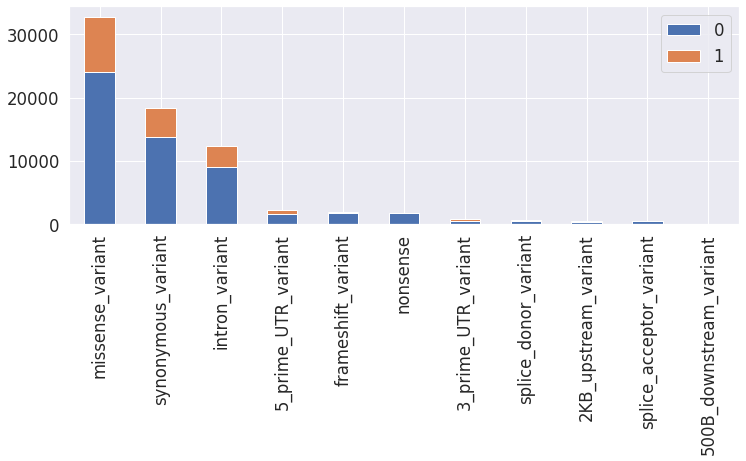

In [64]:
mc_ct.drop('All', axis=0, inplace=True)

mc_ct = mc_ct.sort_values(by='All', ascending=False)
mc_ct.drop('All', axis=1, inplace=True)

mc_ct.plot.bar(stacked=True, figsize=(12, 4));

---
Results from SIFT and PolyPhen software that predict the severity of a variant, in-silico.

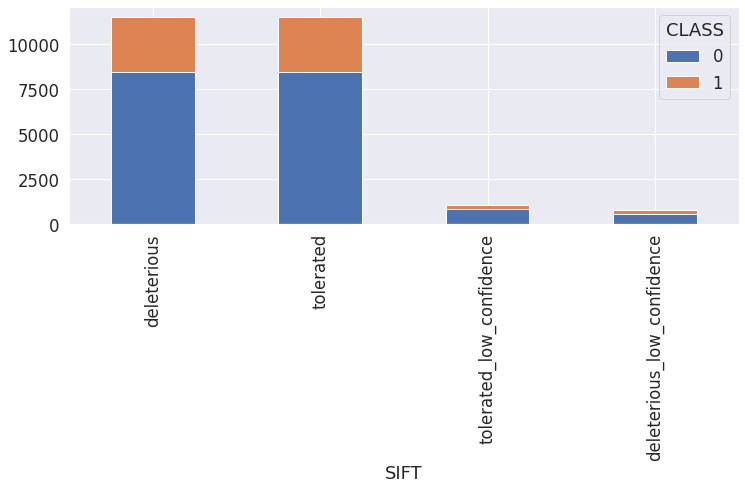

In [68]:
sift_ct = pd.crosstab(df.SIFT, df.CLASS, margins=True)
sift_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
sift_ct = sift_ct.sort_values(by='All', ascending=False)
sift_ct.drop('All', axis=1, inplace=True)

sift_ct.plot.bar(stacked=True, figsize=(12, 4));